In [2]:
#importing os, shutil and glob for copying concrete images from raw folder to the new structure which is 
#required for ImageDataGenerator.flow_from_directory
import os
import shutil
import glob
import cv2
import random
import time
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
%matplotlib inline

#import keras and different type of layers for for defining CNN models
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.metrics import Precision, Recall

from sklearn.decomposition import PCA

In [4]:
def getDataDic():
    baseDir = 'data'
    dic = {}
    train_crack_path = os.listdir(os.path.join(baseDir, 'train/crack/'))
    train_crack = [cv2.resize(cv2.imread(os.path.join(baseDir, 'train/crack/', path)), (448, 448)) for path in train_crack_path]
    dic['train_crack'] = train_crack

    train_uncrack_path = os.listdir(os.path.join(baseDir, 'train/uncrack/'))
    train_uncrack = [cv2.resize(cv2.imread(os.path.join(baseDir, 'train/uncrack/', path)), (448, 448)) for path in train_uncrack_path]
    dic['train_uncrack'] = train_uncrack

    test_crack_path = os.listdir(os.path.join(baseDir, 'test/crack/'))
    test_crack = [cv2.resize(cv2.imread(os.path.join(baseDir, 'test/crack/', path)), (448, 448)) for path in test_crack_path]
    dic['test_crack'] = test_crack

    test_uncrack_path = os.listdir(os.path.join(baseDir, 'test/uncrack/'))
    test_uncrack = [cv2.resize(cv2.imread(os.path.join(baseDir, 'test/uncrack/', path)), (448, 448)) for path in test_uncrack_path]
    dic['test_uncrack'] = test_uncrack

    visualization_crack_path = os.listdir(os.path.join(baseDir, 'visualization/real_images/'))
    visualization_crack = [cv2.resize(cv2.imread(os.path.join(baseDir,'visualization/real_images/',path)), (448, 448)) for path in visualization_crack_path]
    dic['visualization_crack'] = visualization_crack
    
    return dic

In [3]:
def transformDataToApplyPca(dic):
    training_images_list = dic['train_crack'] + dic['train_uncrack']
    y_train = []
    for i in range(len(dic['train_crack'])):
        y_train.append(0)
    for i in range(len(dic['train_uncrack'])):
        y_train.append(1)

    testing_images_list = dic['test_crack'] + dic['test_uncrack']
    y_test = []
    for i in range(len(dic['test_crack'])):
        y_test.append(0)
    for i in range(len(dic['test_uncrack'])):
        y_test.append(1)

    visualization_images_list = dic['visualization_crack']

    temp1 = list(zip(training_images_list, y_train))
    random.shuffle(temp1)
    training_images_list, y_train = zip(*temp1)

    temp2 = list(zip(testing_images_list, y_test))
    random.shuffle(temp2)
    testing_images_list, y_test = zip(*temp2)

    training_images = np.array(training_images_list)
    testing_images = np.array(testing_images_list)
    visualization_images = np.array(visualization_images_list)
    
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    return (training_images, testing_images, visualization_images, y_train, y_test)

In [5]:
def getHighQualityVisualizationImages():
    baseDir = 'data'
    
    images_path = os.listdir(os.path.join(baseDir, 'visualization/real_images/'))
    visualization_images = [cv2.imread(os.path.join(baseDir,'visualization/real_images/',path)) for path in images_path]
    
    return visualization_images

In [6]:
def convertImagesDataFrom3dTo1d(training_images , testing_images, visualization_images):
    #Now let's reshape images to 1-d
    training_data = training_images.reshape((len(training_images), 448*448*3))
    testing_data = testing_images.reshape((len(testing_images), 448*448*3))
    visualization_data = visualization_images.reshape((len(visualization_images), 448*448*3))

    return (training_data, testing_data, visualization_data)

In [7]:
def returnKwith99Info(variance):
    k = 0
    currentSum = 0
    total = sum(variance)
    
    while(currentSum/total) <  0.99:
        currentSum += variance[k]
        k += 1
    return k

In [8]:
def applyPcaAndFindSuitableK(training_data, testing_data, visualization_data):
    pca = PCA()
    pca.fit(training_data)
    
    k = returnKwith99Info(pca.explained_variance_)
    
    pca = PCA(n_components=k)
    transformed_training_data = pca.fit_transform(training_data)
    
    transformed_testing_data = pca.transform(testing_data)
    transformed_visualization_data = pca.transform(visualization_data)
    
    return (transformed_training_data, transformed_testing_data, transformed_visualization_data)

In [9]:
def addExtraDimForConv1D(training_data, testing_data, visualization_data):
    training_data = np.expand_dims(training_data, axis=2)
    testing_data = np.expand_dims(testing_data, axis=2)
    visualization_data = np.expand_dims(visualization_data, axis=2)
    
    return (training_data, testing_data, visualization_data)

In [10]:
def getModel(k):
    model = Sequential()
    
    model.add(Conv1D(filters=6, kernel_size=5, activation='relu', input_shape=(k, 1)))
    model.add(AveragePooling1D(pool_size=2, strides=2))

    model.add(Conv1D(filters=16, kernel_size=5, activation='relu'))
    model.add(AveragePooling1D(pool_size=2, strides=2))
    
    model.add(Dropout(0.5))
    model.add(Flatten())

    model.add(Dense(120))
    model.add(Activation('relu'))
    model.add(Dense(units=84))
    model.add(Activation('relu'))

    model.add(Dense(1)) # this our output layer (since this is binary classification of cracked or uncracked, we use only one unit in output layer).
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])
    
    return model

In [11]:
#let's get data of images
dic = getDataDic()
print(len(dic['train_crack']), len(dic['train_uncrack']), len(dic['test_crack']),
      len(dic['test_uncrack']), len(dic['visualization_crack']))

150 150 45 45 10


In [12]:
#spearate training, testing and visualization images from dictionary of whole images
training_images, testing_images, visualization_images, y_train, y_test = transformDataToApplyPca(dic)
print('Training images = ', len(training_images), ' ', len(y_train))
print('Testing images = ', len(testing_images), ' ', len(y_test))
print('Visualization images = ', len(visualization_images))

Training images =  300   300
Testing images =  90   90
Visualization images =  10


#### Let's Visualize Training Images before applying PCA

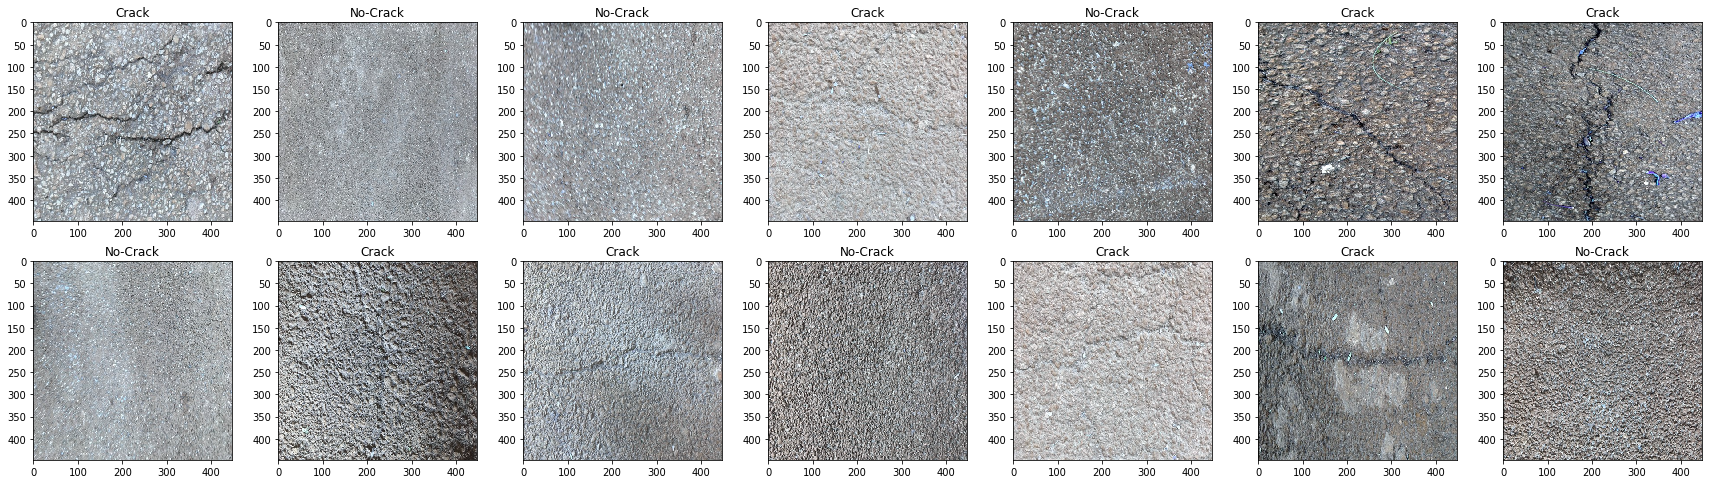

In [13]:
fig = plt.figure(figsize=(30, 30))
for i in range(0, 14, 1):
    ax = fig.add_subplot(7, 7, i+1)
    ax.imshow(training_images[i])
    if(y_train[i] == 0):
        ax.set_title('Crack')
    else:
        ax.set_title('No-Crack')
plt.show()

In [14]:
training_data, testing_data, visualization_data = convertImagesDataFrom3dTo1d(training_images, testing_images, visualization_images)


start_time = time.time()
transformed_training_data, transformed_testing_data, transformed_visualization_data = applyPcaAndFindSuitableK(training_data, testing_data, visualization_data)
finish_time = time.time()
time_taken = finish_time - start_time
print('PCA applied in {:.0f}m {:.0f}s'.format(time_taken // 60, time_taken % 60))


transformed_training_data, transformed_testing_data, transformed_visualization_data = addExtraDimForConv1D(transformed_training_data, transformed_testing_data, transformed_visualization_data)
print('Number of features which contains 99% of total information : ', transformed_training_data.shape[1])

PCA applied in 0m 48s
Number of features which contains 99% of total information :  281


In [16]:
model = getModel(transformed_training_data.shape[1])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 277, 6)            36        
_________________________________________________________________
average_pooling1d_3 (Average (None, 138, 6)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 134, 16)           496       
_________________________________________________________________
average_pooling1d_4 (Average (None, 67, 16)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 67, 16)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1072)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)              

In [17]:
start_time = time.time() 
verbose, epochs, batch_size = 0, 30, 32
model.fit(
    transformed_training_data,
    y_train,
    epochs=epochs,
    validation_data=(transformed_testing_data, y_test)
)
finish_time = time.time()
time_taken = finish_time-start_time
print('\n')
print('Training complete in {:.0f}m {:.0f}s'.format(time_taken // 60, time_taken % 60))


Train on 300 samples, validate on 90 samples
Epoch 1/30
300/300 [==============================] - 2s 6ms/step - loss: 59.6350 - accuracy: 0.5833 - precision_2: 0.5862 - recall_2: 0.5667 - val_loss: 3.9408 - val_accuracy: 0.4556 - val_precision_2: 0.4000 - val_recall_2: 0.1778
Epoch 2/30
300/300 [==============================] - 0s 196us/step - loss: 19.1176 - accuracy: 0.7000 - precision_2: 0.7113 - recall_2: 0.6733 - val_loss: 2.2950 - val_accuracy: 0.5111 - val_precision_2: 0.5116 - val_recall_2: 0.4889
Epoch 3/30
300/300 [==============================] - 0s 176us/step - loss: 13.1025 - accuracy: 0.7000 - precision_2: 0.7000 - recall_2: 0.7000 - val_loss: 2.1301 - val_accuracy: 0.5667 - val_precision_2: 0.5652 - val_recall_2: 0.5778
Epoch 4/30
300/300 [==============================] - 0s 183us/step - loss: 10.4892 - accuracy: 0.7167 - precision_2: 0.7241 - recall_2: 0.7000 - val_loss: 2.1024 - val_accuracy: 0.5111 - val_precision_2: 0.5333 - val_recall_2: 0.1778
Epoch 5/30
300/3

In [18]:
_, accuracy, precision, recall = model.evaluate(transformed_testing_data, y_test, batch_size=batch_size, verbose=verbose)
print(' accuracy : ', accuracy, '\n', 'precision : ', precision, '\n', 'recall : ', recall)

 accuracy :  0.699999988079071 
 precision :  0.8461538553237915 
 recall :  0.4888888895511627


#### VISUALISING PREDICTIONS OF MODEL

In [ ]:
vis_im_hq = getHighQualityVisualizationImages()

predictions = model.predict(transformed_visualization_data)
pred_class_arr = np.array(predictions).round()
counter = 0
for i in range(2):
    fig = plt.figure(figsize=(50, 50))
    for j in range(5):
        axisarr = fig.add_subplot(10, 10, j+1)
        axisarr.imshow(vis_im_hq[counter])
        if(pred_class_arr[counter] == 0):
            axisarr.set_title('Crack')
        else:
            axisarr.set_title('No Crack')
        counter += 1